# Demo: Sing back a melody 

In [44]:
# Before starting, set the right working dir and imports
import os
if 'path_to_dir' not in globals():
    path_to_dir = os.path.split(os.getcwd())[0]
os.chdir(path_to_dir)

# imports
import time
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

from sing4me import singing_extract as sing
from sing4me import melodies as melodies
from params import singing_2intervals, roving_mean, roving_width

# output directory
trial_name = "ising_demo" # name your trial here!

output_dir = "output"
output_file = f"stim_{trial_name}.wav"
recording_file = f"rec_{trial_name}.wav"
output_plot = f"plot_{trial_name}.png"

### Indicate your gender (singing register)

In [45]:
GENDER = "low" # low (center = 49 MIDI) or high (center = 61 MIDI)

## Generate a melody

In [47]:
reference_pitch = melodies.sample_reference_pitch(
    roving_mean[GENDER],
    roving_width["default"]
)

# number notes per melody is flexible
# min_num_pitches = 5
# max_num_pitches = 12
# num_pitches = melodies.sample_num_pitches(min_num_pitches, max_num_pitches)

# number notes per melody is fixed
num_pitches = 5

# select if note duratons are fixed or of can varying in lenght 
note_duration_fixed = False

# generate targer pitches
target_pitches = melodies.sample_absolute_pitches(
    reference_pitch=reference_pitch,
    max_interval2reference=singing_config["max_pitch_height_seed"],
    num_pitches=num_pitches
)
print(f"Melody has {num_pitches} pitches")
print(target_pitches)

Melody has 5 pitches
[42.29003474787838, 40.11119868649196, 38.835699561041274, 42.786122135670254, 52.88248021262826]


In [48]:
if note_duration_fixed:
    NOTE_DURATION = 0.5
    NOTE_IOI = 0.8
    durations = [NOTE_DURATION for _ in target_pitches]
    onsets = [i * NOTE_IOI for i in range(len(target_pitches))]
    duration_recording = (sum(onsets))

else:
    durations = [0.25, 0.25, 0.5, 0.5, 2]
    silences = [0.3] * len(durations)
    NOTE_IOI = [element1 + element2 for (element1, element2) in zip(durations, silences)] 
    NOTE_IOI.insert(0, 0)  # insert first oneset at 0 ms
    NOTE_IOI = np.cumsum(NOTE_IOI) # get onsets
    NOTE_IOI = NOTE_IOI[:-1]  # remove onset after last note
    onsets = [i for i in NOTE_IOI]
    duration_recording = (sum(onsets))
    
print(durations)
print(onsets)
print(duration_recording)

[0.25, 0.25, 0.5, 0.5, 2]
[0.0, 0.55, 1.1, 1.9000000000000001, 2.7]
6.25


In [49]:
# save melody
sing.generate_sine_tones(
    target_pitches,
    durations,
    onsets,
    singing_config["sample_rate"],
    os.path.join(output_dir,output_file)
)

## Recording: get ready to sing! 

In [50]:
import sounddevice as sd
import soundfile as sf
from scipy.io import wavfile

def save_samples_to_file(samples, filename, fs):
    wavfile.write(filename, rate=fs, data=samples.astype(np.float32))

print("Listen to the melody")
audio_data, SAMPLE_RATE = sf.read(os.path.join(output_dir,output_file), dtype='float32')
sd.play(audio_data, SAMPLE_RATE)
status = sd.wait()
print("WAIT IN SILENCE..")
time.sleep(3)

print("SING THE MELODY BACK!")
myrecording = sd.rec(int((duration_recording + 2) *  SAMPLE_RATE), samplerate=  SAMPLE_RATE, channels=1)
status = sd.wait()

# save recording to wav
save_samples_to_file(
    myrecording,
    os.path.join(output_dir,recording_file),
    SAMPLE_RATE)

print("Finished")

Listen to the melody
WAIT IN SILENCE..
SING THE MELODY BACK!
Finished


## Analysis & Results

In [51]:
# extract sung pitches and intervals
raw = sing.analyze(
    os.path.join(output_dir,recording_file),
    singing_config,
    target_pitches=target_pitches,
    plot_options=sing.PlotOptions(
        save=True, path= os.path.join(output_dir, output_plot), format="png"
    ),
)

raw = [{key: melodies.as_native_type(value) for key, value in x.items()} for x in raw]
sung_pitches = [x["median_f0"] for x in raw]
sung_intervals = melodies.convert_absolute_pitches_to_interval_sequence(
            sung_pitches,
             "previous_note"
        )

target_intervals = melodies.convert_absolute_pitches_to_interval_sequence(
    target_pitches,
    "previous_note"
)
stats = sing.compute_stats(
    sung_pitches,
    target_pitches,
    sung_intervals,
    target_intervals
)
print(f"sung pitches: {sung_pitches}")
print(f"target pitches: {target_pitches}")
print(f"sung intervals: {sung_intervals}")
print(f"target intervals: {target_intervals}")

# print(f"stats: {stats}")

selected$("Sound")Plot saved
sung pitches: [46.274064890873916, 44.20447741848386, 42.97767294342391, 46.964181240254185, 52.346704903021504]
target pitches: [42.29003474787838, 40.11119868649196, 38.835699561041274, 42.786122135670254, 52.88248021262826]
sung intervals: [-2.0695874723900545, -1.22680447505995, 3.986508296830273, 5.382523662767319]
target intervals: [-2.17883606138642, -1.2754991254506862, 3.9504225746289805, 10.096358076958005]


In [52]:
# extract onsets
MIN_NOTE_DURATION = 0.25
silence_durations, note_durations, ISIs = sing.extract_onsets(raw, MIN_NOTE_DURATION)

print(f"note_durations: {note_durations}")
print(f"silence_durations: {silence_durations}")
print(f"ISIs: {ISIs}")


note_durations: [0.3434013605442178, 0.40113378684807255, 0.3882539682539682, 0.44863945578231323, 1.4201814058956916]
silence_durations: [0.46333333333333326, 0.3256009070294785, 0.6826984126984126, 0.5640589569160993, 0.5]
ISIs: [0.806734693877551, 0.7267346938775511, 1.0709523809523809, 1.0126984126984127]


## Determine whether the trail should fail

In [53]:
# Failing criteria
is_failed = melodies.failing_criteria(
                sung_intervals,
                sung_pitches,
                reference_pitch,
                singing_config["num_int"],
                singing_config["max_interval_size"],
                singing_config["max_melody_pitch_range"],
                singing_config["reference_mode"],
                stats,
                singing_config["max_abs_interval_error_treshold"],
                singing_config["max_pitch_height"]
            )


print(f"Is it failed? {is_failed['failed']}")
print(f"Reason: {is_failed['reason']}")

Is it failed? False
Reason: All good


## Plot 

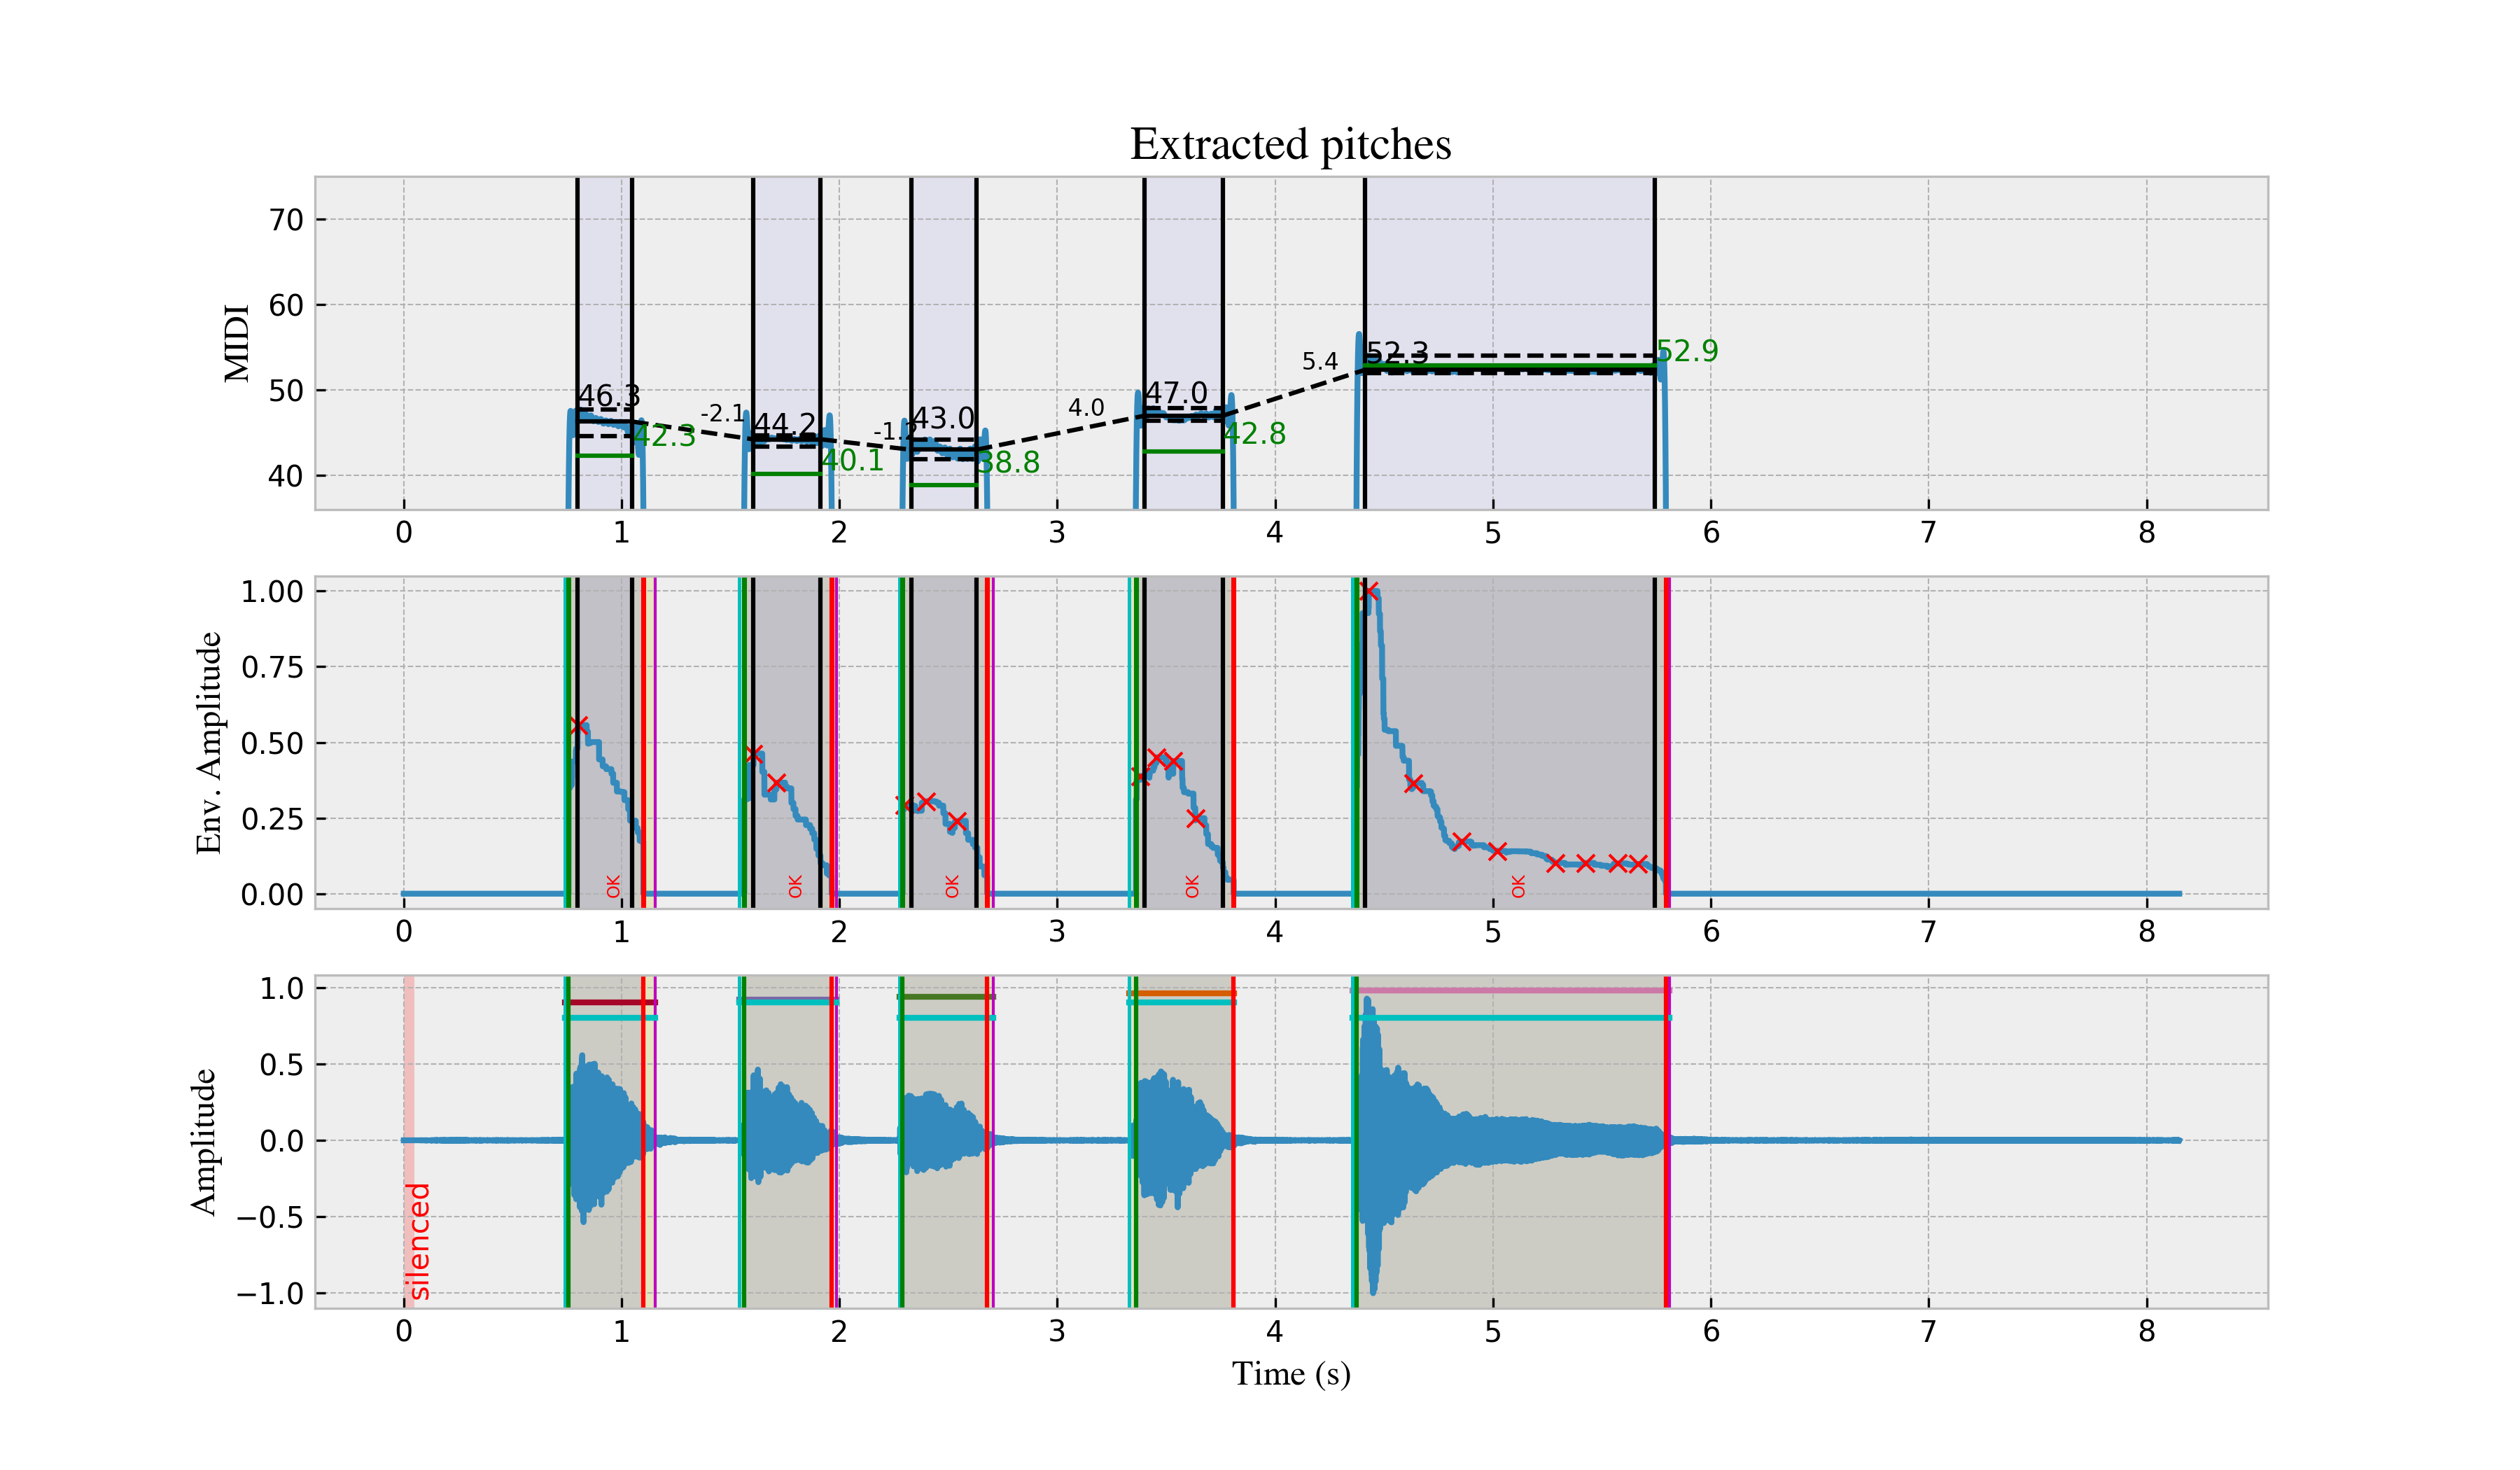

In [54]:
from IPython import display
display.Image(os.path.join(output_dir, output_plot))